In [1]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [8]:
import os 
import keras
import numpy as np 
from tqdm import tqdm 
import tensorflow as tf

import pandas as  pd
# Data 
import scipy.ndimage as mp
from glob import glob
import pathlib
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi

# Model prepare
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt


from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence
import albumentations as A


In [9]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as smp;

env: SM_FRAMEWORK=tf.keras


In [10]:
#ссылоки на изображения и маски
images = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
masks = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/matting/*/*/*'))

In [11]:
def see_pict(image,mask):
    plt.figure(figsize=(9, 5))
    plt.subplot(1,2,1)
    im = plt.imread(image)
    plt.imshow(im)
    plt.subplot(1,2,2)
    label = load_img(mask)
    label = img_to_array(label)[:,:,0]
    label = label != 0
    label = tf.cast(label/255.0, tf.float64)
    plt.imshow(label)
    plt.show()



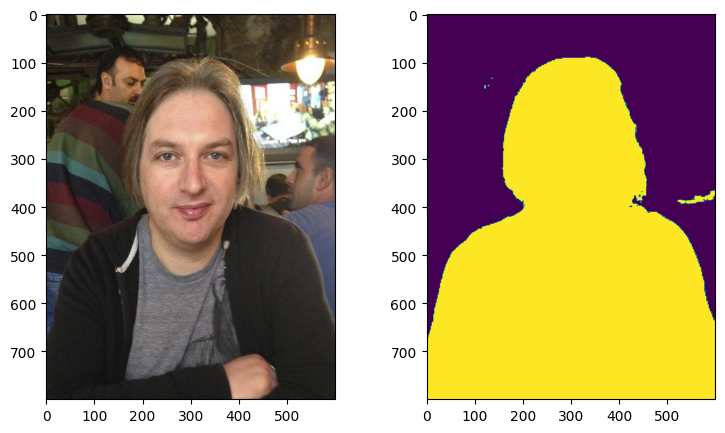

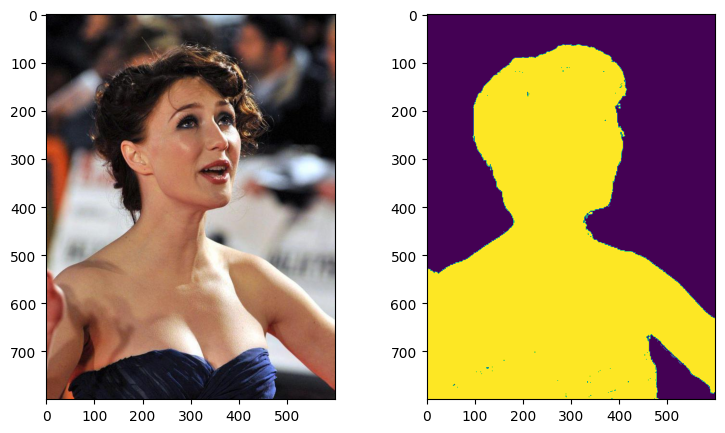

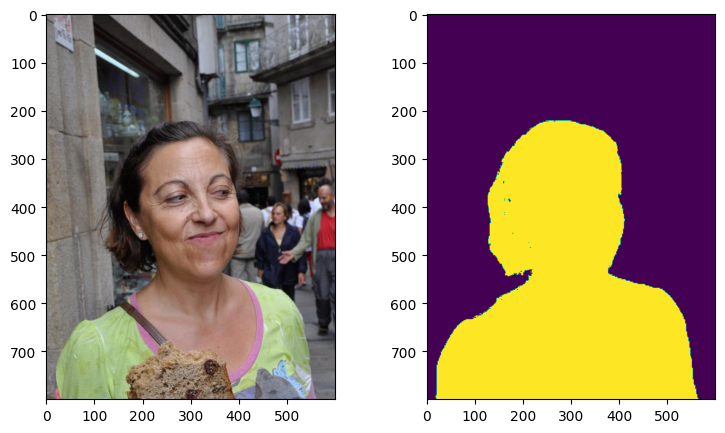

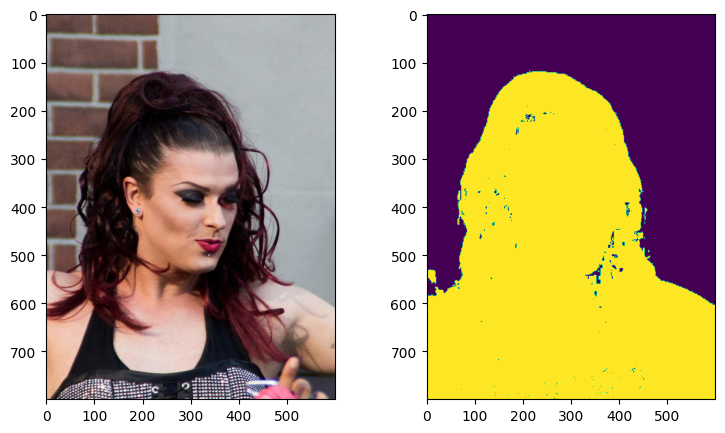

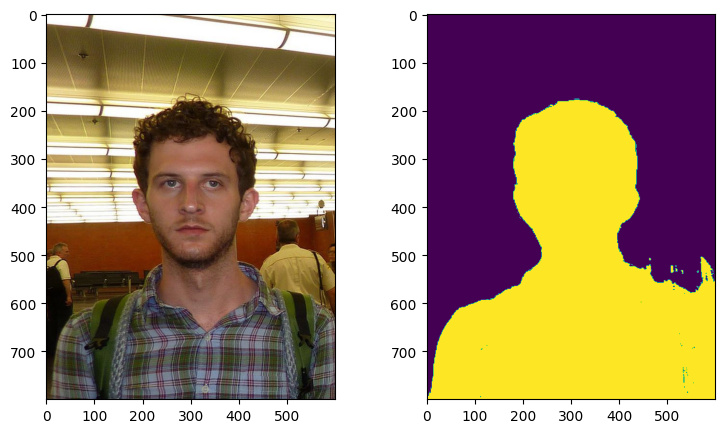

In [36]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    see_pict(image, mask)

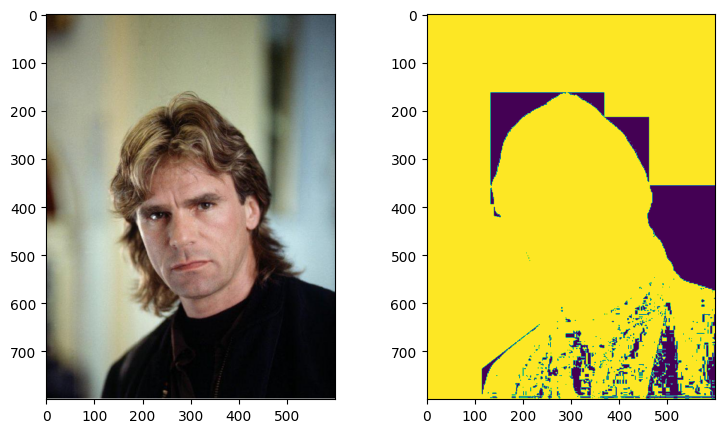

In [40]:
see_pict(images[87], masks[87])

## Problem
Often when we create a mask from png image we have mask with holes. It occurs becouse the black colour in image matrics equal 0. So if image have deep black collours it often have holes when we create mask some ways like mask = mask!=0. Also particulary this dataset probaly have  mask with some parts of bacground aspecialy when background have the skin or hair colours. The holes in the picture will be a big problem for educatiol provces.  
First - For model it is harder to remmember comprehansive mask with hols that the proper mask.  
Second - Even if we have a good models on our train and test dataset it works bad on real data. And our model will create hole in real picture so when we cut the image using mask we have this holes. It could make holes when peopel have deep black colour like eyse or hair.  
Below we try some trics to make a proper mask 


## Some functionals for manipulating with Brightnes and Contrast

## Brightnes and Conrast

In [78]:
def increase_brightness(img, value=100):
    img = plt.imread(img)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return img

def contrast(image, value=1):
    img = cv.imread(image, 1)
    img = image
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv.split(lab)  # split on 3 different channels

    l2 = clahe.apply(l)  # apply CLAHE to the L-channel

    lab = cv.merge((l2,a,b))  # merge channels
    img2 = cv.cvtColor(lab, cv.COLOR_LAB2BGR)  # convert from LAB to BGR
    return img2

def lighting_image(img, value=90):
    img = plt.imread(img)
    img = np.array(img) / 255
    img = img + img * value
    img[img > 1] = 1
    return img

In [74]:
def masking_problem_br_con(img, mask, transform):
    
    plt.figure(figsize=(19, 5))
    plt.subplot(1,5,1)
    im = plt.imread(img)
    plt.title("Image")
    plt.imshow(im)
    
    plt.subplot(1,5,2)
    #m = plt.imread(mask)
    m = transform(mask, value=100)
    m = m!=0
    m = m[:,:,0]
    plt.title("Mask with manipulations")
    plt.imshow(m)
    
    plt.subplot(1,5,3)
    m = plt.imread(mask)
    m = m!=0
    m=m[:,:,0]
    plt.title("Mask without manipulations")
    plt.imshow(m)

    plt.subplot(1,5,4)
    m = plt.imread(mask)
    plt.title("Matting")
    plt.imshow(m)


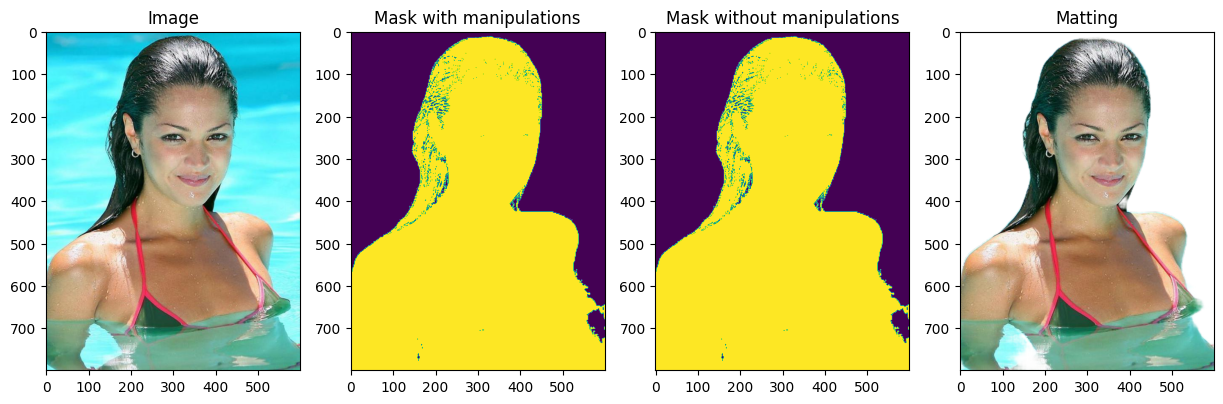

In [76]:
masking_problem_br_con(images[7], masks[7], lighting_image)

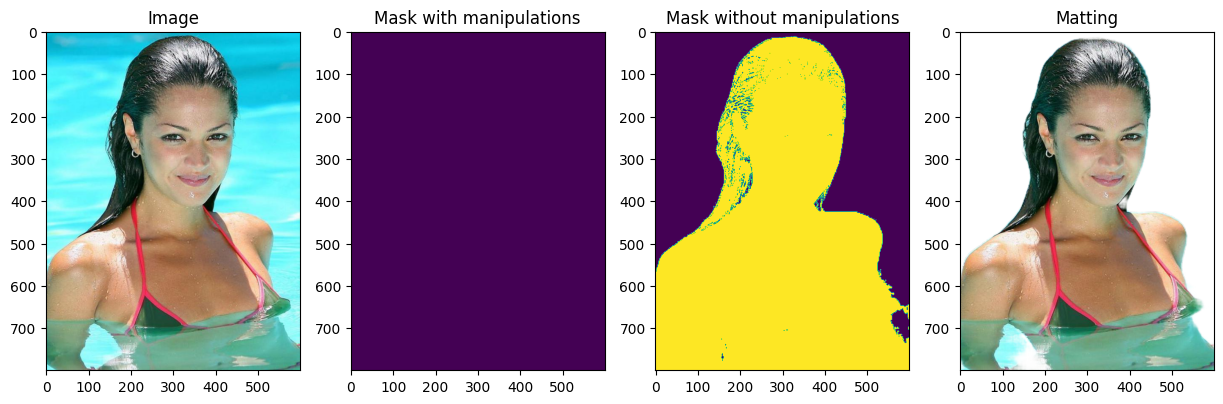

In [79]:
masking_problem_br_con(images[7], masks[7], increase_brightness)

## Using ResizeMethode from Tensorflow

In [82]:
def masking_problem_resize(img, mask, method=tf.image.ResizeMethod.LANCZOS5, multiply=False):
    
    plt.figure(figsize=(19, 5))
    plt.subplot(1,5,1)
    im = plt.imread(img)
    plt.title("Image")
    plt.imshow(im)
    
    plt.subplot(1,5,2)
    m = plt.imread(mask)
    if method == None:
        m = tf.image.resize(m,(im.shape[0], im.shape[1]), method=method)
    if  multiply !=False
        m = 10e7*m[:,:,0] + 10e7*m[:,:,1] + 10e7*m[:,:,2]
    m = m[:,:,0]
    m = m!=0
    
    plt.title("Mask with manipulations")
    plt.imshow(m)
    
    plt.subplot(1,5,3)
    m = plt.imread(mask)
    m = m!=0
    m=m[:,:,0]
    plt.title("Mask without manipulations")
    plt.imshow(m)

    plt.subplot(1,5,4)
    m = plt.imread(mask)
    plt.title("Matting")
    plt.imshow(m)


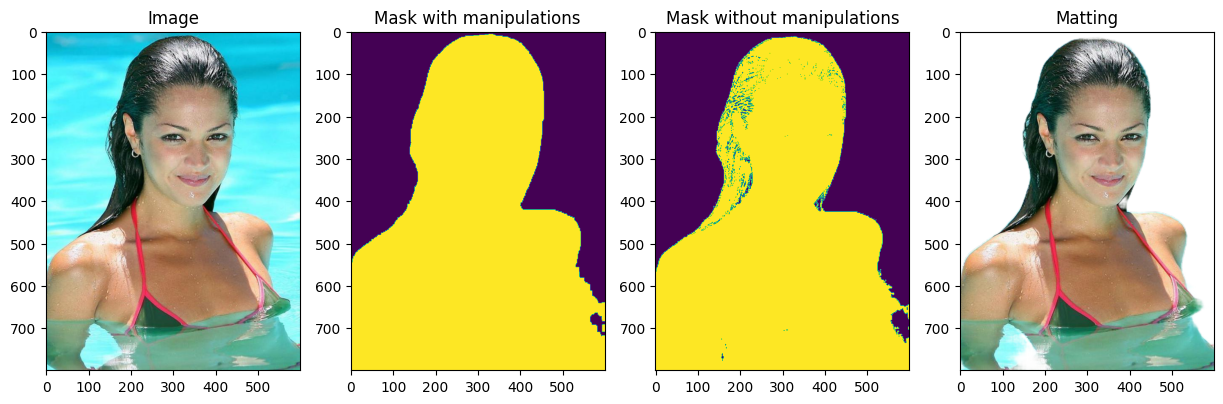

In [83]:
 masking_problem(images[7], masks[7], method=tf.image.ResizeMethod.LANCZOS5)

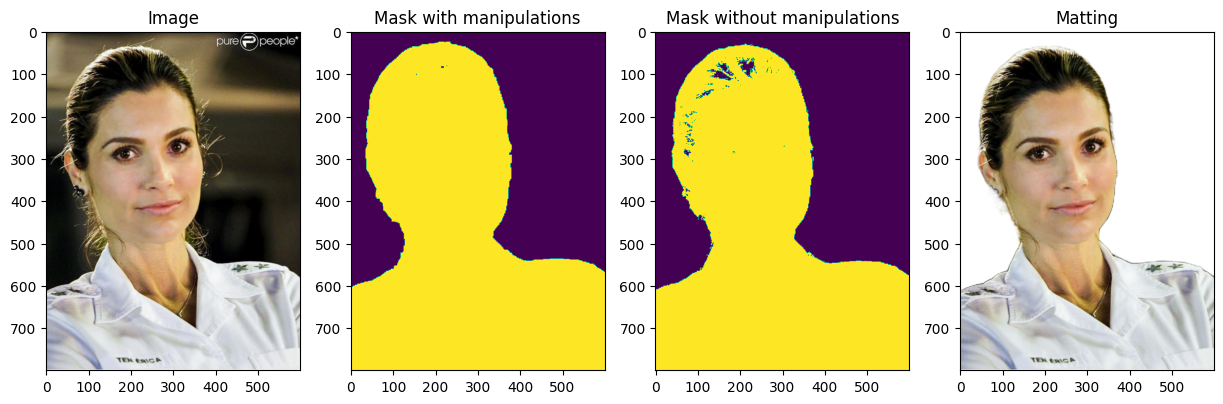

In [88]:
masking_problem_resize(images[6], masks[6], method=tf.image.ResizeMethod.LANCZOS5)

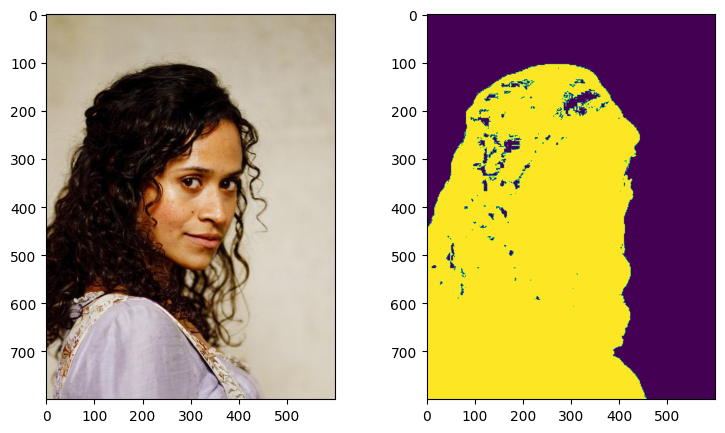

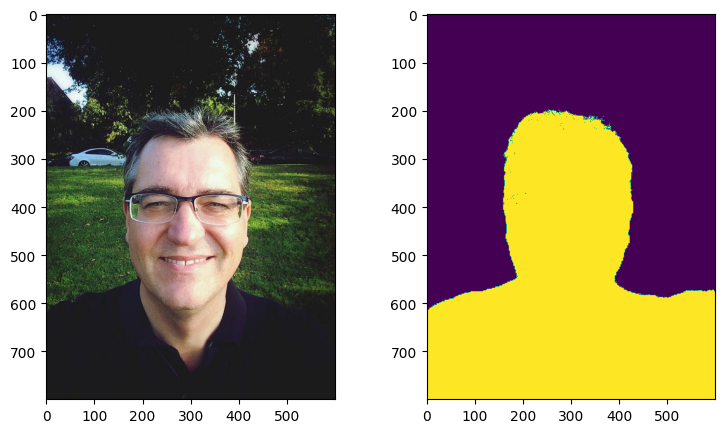

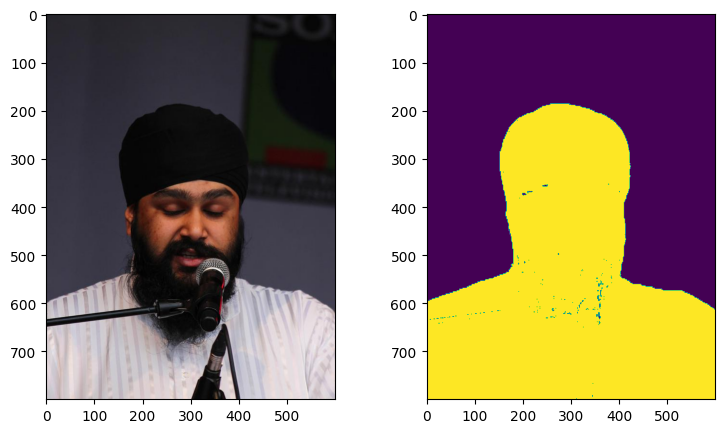

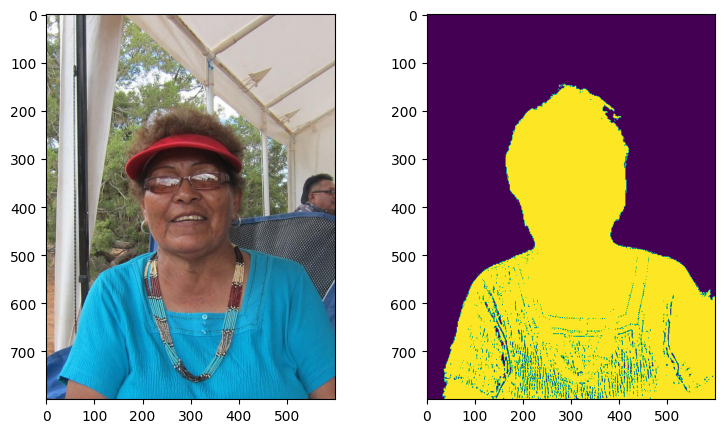

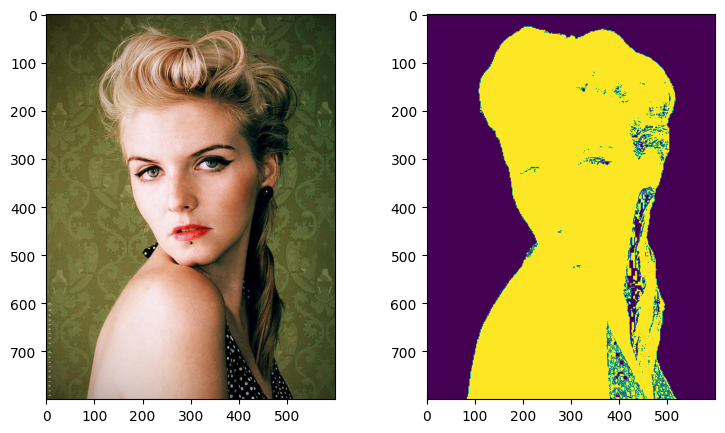

In [7]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    see_pict(image, mask)

## Using Scaning Vector String 

See for picture vector by vector (string) and fill with ones this vectors from first number to the last number if this number is not 0

In [9]:
def matting_solution(img, mask):
    # единственная проблема что не оч быстро работает
    # надо попробовать работать сразу со всей матрицей а не вектор строкой
        
    m = plt.imread(mask)
    m = m[:,:,0]
    m = (m[:,:]>0).astype(np.float16)
    
    for i, vector in enumerate(m):
        Z = np.zeros_like(vector)
        O = np.ones_like(vector)
        one_indexs = []
        
        for i2, el in enumerate(vector):
            if el > 0:
                one_indexs.append(i2)
        if one_indexs:
            Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
            m[i,:] = Z
            
            
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    image = cv.imread(img, cv.COLOR_BGR2RGB)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.title("Исходное Изображение")
    plt.imshow(image)
        
    plt.subplot(1, 3, 2)
    plt.title("Маска")
    mask = cv.imread(mask)
    mask = (mask[:,:,0]>0).astype(np.float32) #mask = np.where(mask > 0, 1, mask)
    plt.imshow(mask)
        
    plt.subplot(1, 3, 3)
    
    plt.title("Измененая Маска")
    plt.imshow(m);
       

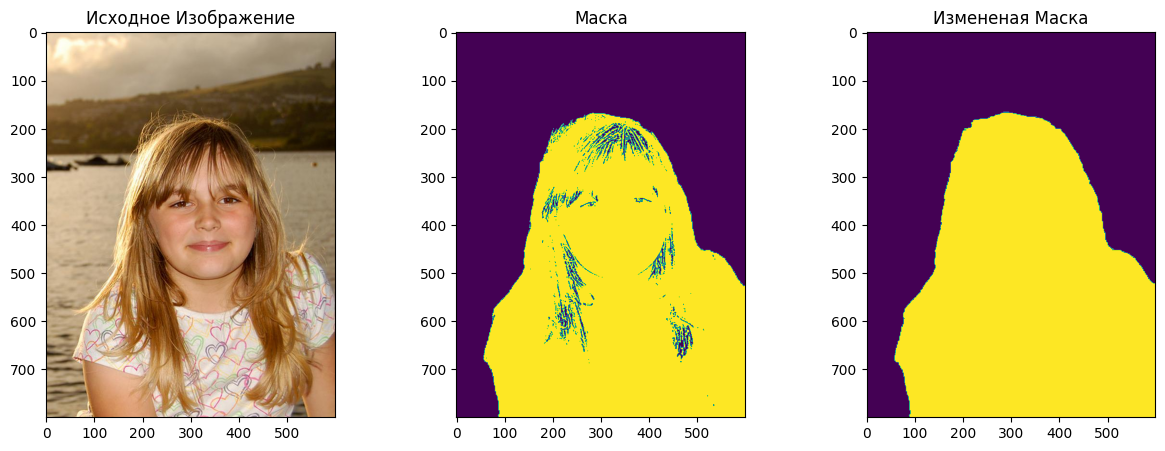

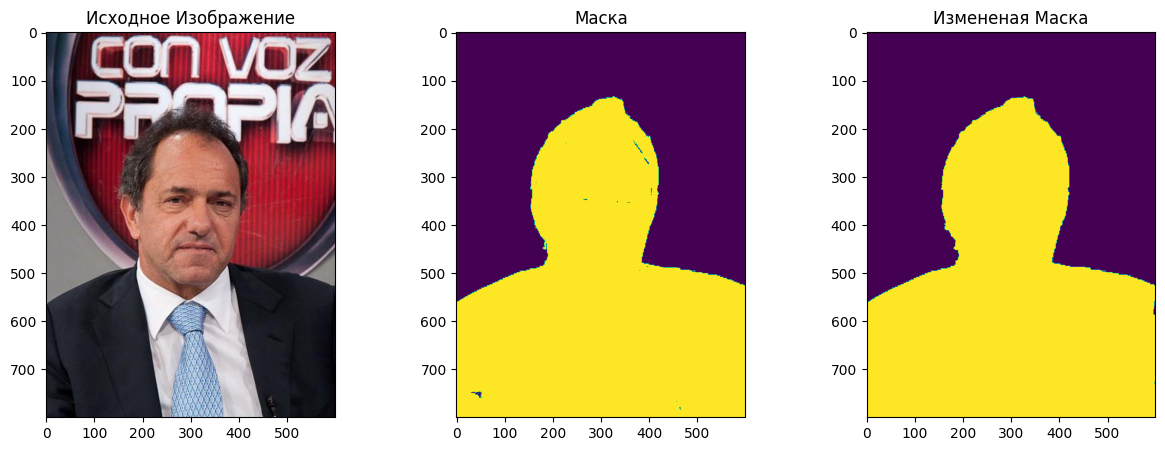

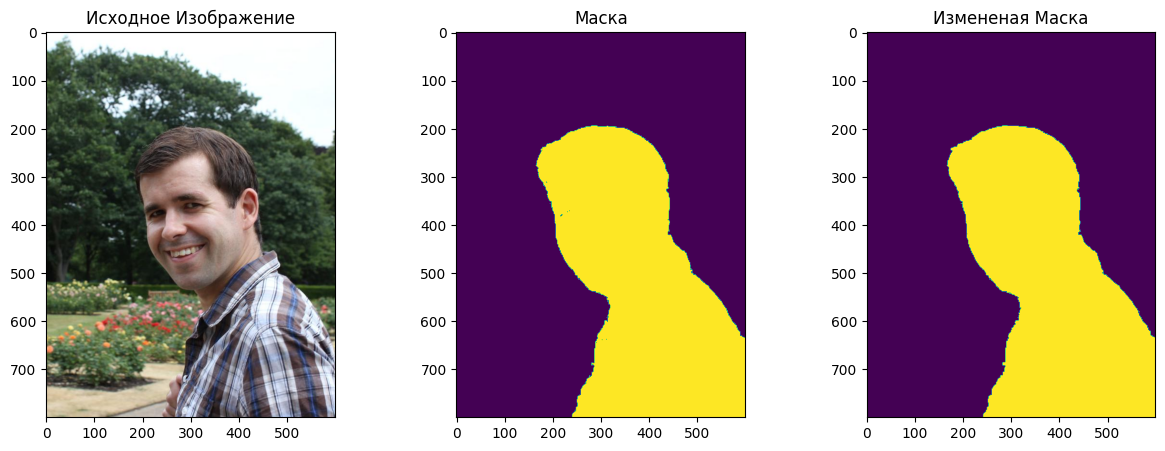

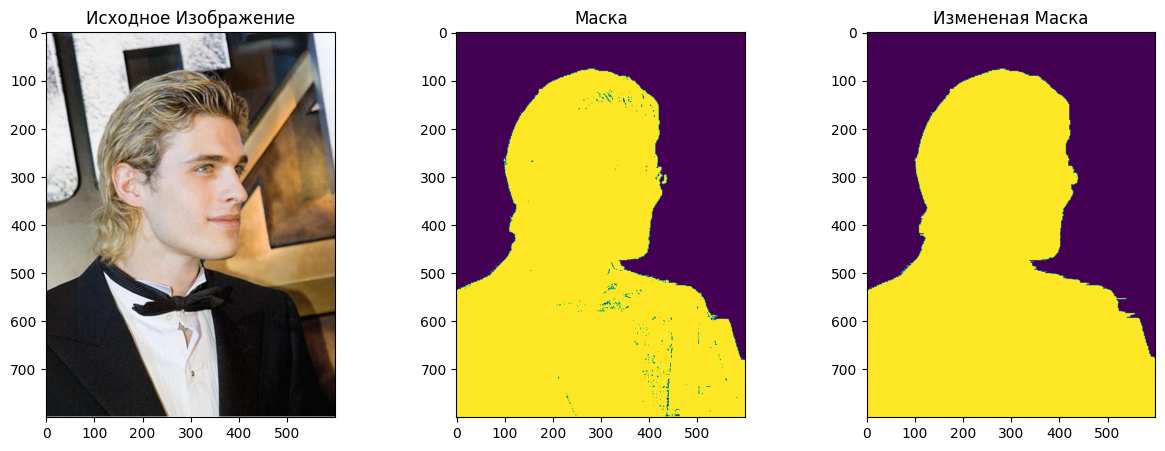

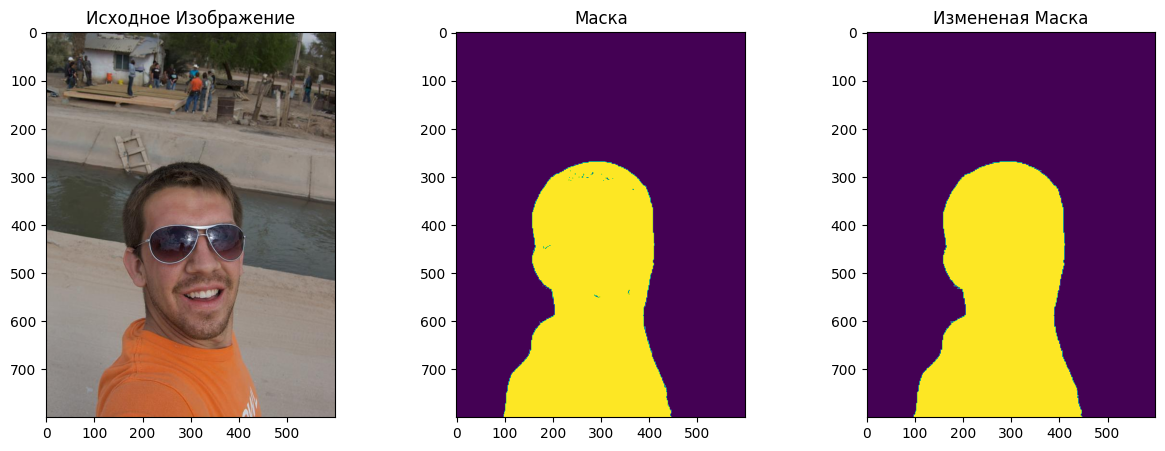

In [11]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    matting_solution(image, mask)

## Matrics Scaning 
Using matrics for 

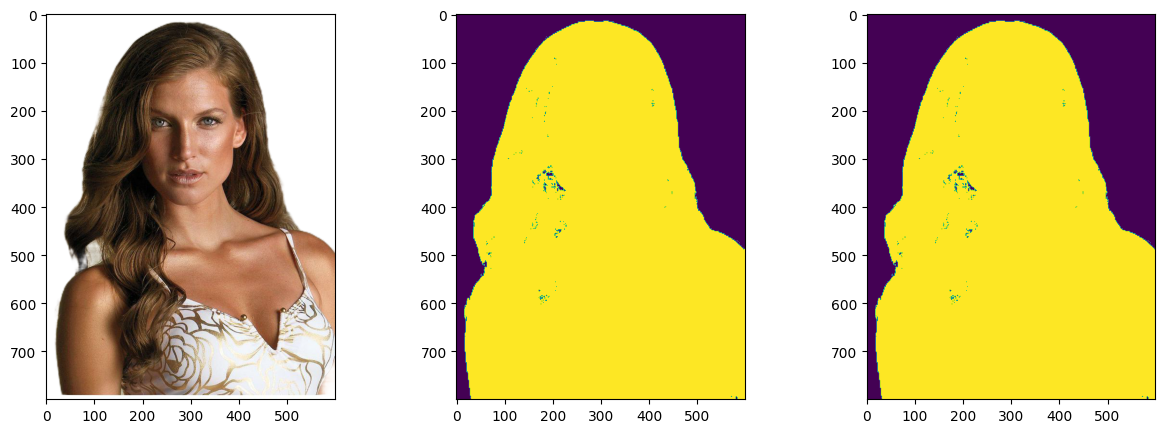

In [112]:
def matting_solution_matrix_trics(mask, size=9, step=4):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    M = plt.imread(mask)
    plt.imshow(M)
    M = M[:,:,0]
    M = (M[:,:]>0).astype(np.float16)
    plt.subplot(1,3,2)
    plt.imshow(M)
    i = 0
    j = 0
    half = M.shape[1]/2
    Z = np.zeros(size)
    O = np.ones(size)

    for i in range(M.shape[0]-size):
        # лок на строки
        n = i+size
        for j in range(M.shape[1]-size):
        
    #while i < M.shape[0]-size and j <  M.shape[1]-size: #по диагонали идет
            try:
                M_ = M[i: n, j: j+size]
                J = M[i: n, j+size] #vector 
                M_sum = np.sum(M_)
                J_sum = np.sum(J)
                if M_sum >= 5 and J_sum < 1:
                    M[i: n, j: j+size]= Z
                elif M_sum > 0 and J_sum <= 4:
                    M[i: n, j: j+size] = O
                i, j = i + step, j+step
                #print(M_sum, J_sum)
            except (IndexError, ValueError):
                pass
            #print(M_sum, J_sum)
    
  

    plt.subplot(1,3,3)
    plt.imshow(M)
    plt.show()

    
            

matting_solution_matrix_trics(masks[76], size=7, step=3)